In [1]:
# Importing the libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

import numpy as np
from tensorflow.keras.preprocessing import image

In [2]:
#data sugmentation
# Preprocessing the Training set
train_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')
training_set = train_datagen.flow_from_directory('image_data/training',
                                                 target_size = (224,224),
                                                 batch_size = 198,
                                                 class_mode = 'binary')

Found 198 images belonging to 2 classes.


In [3]:
# Preprocessing the Test set
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('image_data/validation',
                                            target_size = (224,224),
                                            batch_size = 100,
                                            class_mode = 'binary')

Found 100 images belonging to 2 classes.


In [4]:
X_train, y_train = next(training_set)
y_train = y_train.astype(int)

X_test, y_test = next(test_set)
y_test = y_test.astype(int)

In [5]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((198, 224, 224, 3), (198,), (100, 224, 224, 3), (100,))

In [6]:
training_set.class_indices

{'Cat': 0, 'Dog': 1}

## Apply Smote For Balancing Data

In [7]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_rows=len(X_train)
X_train_reshape =X_train.reshape(X_train_rows,-1)
X_train_resample, y_train_resample = sm.fit_resample(X_train_reshape, y_train)
X_train_resample = X_train_resample.reshape(-1,224, 224, 3)

In [8]:
X_val_rows=len(X_test)
X_val_reshape =X_test.reshape(X_val_rows,-1)
X_val_resample, y_val_resample = sm.fit_resample(X_val_reshape, y_test)
X_val_resample = X_val_resample.reshape(-1,224, 224, 3)

In [9]:
X_train_resample.shape,y_train_resample.shape,X_val_resample.shape,y_val_resample.shape

((198, 224, 224, 3), (198,), (100, 224, 224, 3), (100,))

## Overview Of Image

In [10]:
## showing some image from training
import matplotlib.pyplot as plt
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

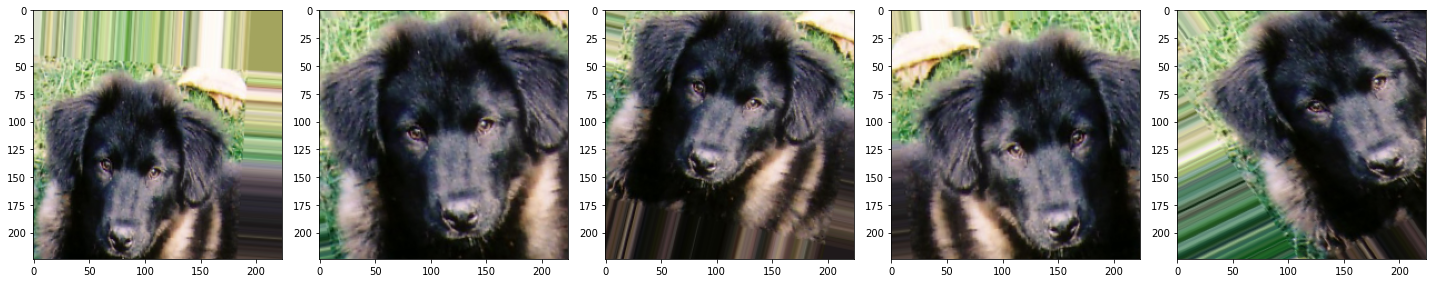

In [11]:
images = [training_set[0][0][0] for i in range(5)]
plotImages(images)

## Using Machine Learning

In [12]:
#sklearn expects i/p to be 2d array-model.fit(x_train,y_train)=>reshape to 2d array
nsamples, nx, ny, nrgb = X_train_resample.shape
x_train2 = X_train_resample.reshape((nsamples,nx*ny*nrgb))

nsamples, nx, ny, nrgb = X_val_resample.shape
x_test2 = X_val_resample.reshape((nsamples,nx*ny*nrgb))

In [13]:
x_train2.ndim

2

In [14]:
x_train2.shape,x_test2.shape,y_train.shape,y_test.shape

((198, 150528), (100, 150528), (198,), (100,))

## Implementing a Random Forest Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(random_state=21)
model.fit(x_train2,y_train_resample)
y_pred=model.predict(x_test2)
print(accuracy_score(y_pred,y_val_resample))
print(classification_report(y_pred,y_val_resample))

0.62
              precision    recall  f1-score   support

           0       0.66      0.61      0.63        54
           1       0.58      0.63      0.60        46

    accuracy                           0.62       100
   macro avg       0.62      0.62      0.62       100
weighted avg       0.62      0.62      0.62       100



## Implementing a KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train2,y_train_resample)
y_pred_knn=knn.predict(x_test2)
print(accuracy_score(y_pred_knn,y_val_resample))
print(classification_report(y_pred_knn,y_val_resample))

0.53
              precision    recall  f1-score   support

           0       0.50      0.53      0.52        47
           1       0.56      0.53      0.54        53

    accuracy                           0.53       100
   macro avg       0.53      0.53      0.53       100
weighted avg       0.53      0.53      0.53       100



## Implementing a Decision Tree

In [17]:
from sklearn.tree import DecisionTreeClassifier
dtc=DecisionTreeClassifier()
dtc.fit(x_train2,y_train_resample)
y_pred_dtc=dtc.predict(x_test2)
print(accuracy_score(y_pred_dtc,y_val_resample))
print(classification_report(y_pred_dtc,y_val_resample))

0.54
              precision    recall  f1-score   support

           0       0.60      0.54      0.57        56
           1       0.48      0.55      0.51        44

    accuracy                           0.54       100
   macro avg       0.54      0.54      0.54       100
weighted avg       0.55      0.54      0.54       100



## Implementing a ANN

In [18]:
from tensorflow.keras.layers import Dense,Input, Flatten
from tensorflow.keras.models import Model,Sequential

In [19]:
model = Sequential()
##input layer
model.add(Dense(100,input_dim = 150528,activation = "relu"))

##2nd laer
model.add(Dense(50,activation = "relu"))

##3rd laer
model.add(Dense(10,activation = "relu"))

##like this you add number of layer all in regression and classification

## output layer
model.add(Dense(1,activation = "sigmoid"))

In [20]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(x_train2,y_train_resample, batch_size=32, epochs=2, validation_data=(x_test2,y_val_resample))

Epoch 1/2
7/7 [==============================] - 2s 223ms/step - loss: 16.3821 - accuracy: 0.4798 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/2
7/7 [==============================] - 1s 166ms/step - loss: 1.0738 - accuracy: 0.4798 - val_loss: 0.6931 - val_accuracy: 0.5000


In [21]:
y_pred_ann=model.predict(x_test2)
y_pred_ann = np.argmax(y_pred_ann, axis=1) 

In [22]:
print(accuracy_score(y_pred_ann,y_val_resample))
print(classification_report(y_pred_ann,y_val_resample))

0.5
              precision    recall  f1-score   support

           0       1.00      0.50      0.67       100
           1       0.00      0.00      0.00         0

    accuracy                           0.50       100
   macro avg       0.50      0.25      0.33       100
weighted avg       1.00      0.50      0.67       100



c:\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# classes = ['cat','dog']

In [24]:
# test_image = image.load_img('dog.jpg', target_size = (224,224))
# test_image = image.img_to_array(test_image)
# #so,eventually,model.predict() should also be a 2d inpu
# nx, ny, nrgb = test_image.shape
# test_image= test_image.reshape(1,(nx*ny*nrgb))

# test_image=test_image/255
# # test_image = np.expand_dims(test_image, axis = 0)
# result = dtc.predict(test_image)[0]
# classes[result]

## Using deep learning CNN Architecture

In [25]:
from tensorflow.keras.layers import Conv2D

In [26]:
# Part 2 - Building the CNN

# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - # Adding a first convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32,padding="same",kernel_size=3, activation='relu', input_shape=[224,224, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a second convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32,padding='same',kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

###ann layer
tf.keras.layers.Dropout(0.5)
# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
tf.keras.layers.Dropout(0.5)

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [27]:
# Compiling the CNN
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Training the CNN on the Training set and evaluating it on the Test set
history = cnn.fit(X_train_resample,y_train_resample, validation_data = (X_val_resample,y_val_resample), epochs = 2)

Epoch 1/2
7/7 [==============================] - 14s 2s/step - loss: 1.4986 - accuracy: 0.6162 - val_loss: 0.8846 - val_accuracy: 0.5000
Epoch 2/2
7/7 [==============================] - 12s 2s/step - loss: 0.7031 - accuracy: 0.5909 - val_loss: 0.7337 - val_accuracy: 0.5600


In [28]:
# Score trained model.
scores = cnn.evaluate(X_val_resample,y_val_resample, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = cnn.predict(X_val_resample)
Y_pred_classes = np.argmax(pred, axis=1) 

4/4 [==============================] - 1s 302ms/step - loss: 0.7337 - accuracy: 0.5600
Test loss: 0.7336697578430176
Test accuracy: 0.5600000023841858


### Custom Prediction

In [29]:
# # Part 4 - Making a single prediction

# import numpy as np
# from tensorflow.keras.preprocessing import image
# test_image = image.load_img('6.jpg', target_size = (224,224))
# test_image = image.img_to_array(test_image)
# test_image=test_image/255
# test_image = np.expand_dims(test_image, axis = 0)
# result = cnn.predict(test_image)[0]
# if result[0]<=0.5:
#     print("The image classified is cat")
# else:
#     print("The image classified is dog")

## Using Transfer Learning

In [30]:
from tensorflow.keras.applications import MobileNet
from keras import Model,Sequential

In [31]:
# Load the pre-trained MobileNetV2 model

# base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3))

# # Freeze the pre-trained layers
# for layer in base_model.layers:
#     layer.trainable = False

# # Add a new output layer with sigmoid activation function
# x = Flatten()(base_model.output)
# x = Dense(units=1, activation='sigmoid')(x)

# # Create the new model with modified output layer
# model = Model(inputs=base_model.input, outputs=x)

#or----------------------------------------------------------------------------------------

mobile_net = MobileNet(input_shape=(224,224,3),weights='imagenet')
mobile_net.trainable = False

model = Sequential([
    mobile_net,
    ### ann layer
    tf.keras.layers.Dense(1, activation='sigmoid') #[0, 1] or [1, 0]
    ])

In [32]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train_resample,y_train_resample,
    epochs=2,
    validation_data=(X_val_resample,y_val_resample)
    )

Epoch 1/2
7/7 [==============================] - 14s 2s/step - loss: 0.6903 - accuracy: 0.6414 - val_loss: 0.6899 - val_accuracy: 0.6900
Epoch 2/2
7/7 [==============================] - 11s 2s/step - loss: 0.6883 - accuracy: 0.6970 - val_loss: 0.6880 - val_accuracy: 0.7200


In [33]:
# Score trained model.
scores = model.evaluate(X_val_resample,y_val_resample, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model.predict(X_val_resample)
Y_pred_classes = np.argmax(pred, axis=1) 

4/4 [==============================] - 4s 803ms/step - loss: 0.6880 - accuracy: 0.7200
Test loss: 0.6880472302436829
Test accuracy: 0.7200000286102295


## Using LSTM

In [34]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

In [35]:
x_train2.shape,x_test2.shape

((198, 150528), (100, 150528))

In [36]:
x_train2 = x_train2.reshape(x_train2.shape[0],x_train2.shape[1]//150528,150528)
x_test2 = x_test2.reshape(x_test2.shape[0],x_test2.shape[1]//150528,150528)

In [37]:
x_train2.shape,x_test2.shape

((198, 1, 150528), (100, 1, 150528))

In [38]:
model = Sequential()
model.add(LSTM(288, input_shape=( 1, 150528), return_sequences = True))
model.add(LSTM(288,activation='relu'))
model.add(Dense(1,activation='tanh'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 288)            173741184 
                                                                 
 lstm_1 (LSTM)               (None, 288)               664704    
                                                                 
 dense_7 (Dense)             (None, 1)                 289       
                                                                 
Total params: 174,406,177
Trainable params: 174,406,177
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train2, y_train, epochs=2, validation_data=(x_test2, y_test),batch_size=256, verbose=2)

Epoch 1/2
1/1 - 11s - loss: 5.4744 - accuracy: 0.5000 - val_loss: 0.8466 - val_accuracy: 0.5000 - 11s/epoch - 11s/step
Epoch 2/2
1/1 - 3s - loss: 0.8455 - accuracy: 0.5000 - val_loss: 0.8717 - val_accuracy: 0.5000 - 3s/epoch - 3s/step


In [40]:
# Score trained model.
scores = model.evaluate(x_test2, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model.predict(x_test2)
Y_pred_classes = np.argmax(pred, axis=1) 

4/4 [==============================] - 1s 266ms/step - loss: 0.8717 - accuracy: 0.5000
Test loss: 0.8716506361961365
Test accuracy: 0.5


# Ensemble

## TWO CNN

In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Concatenate,Dense,Input, Conv2D, MaxPooling2D, Flatten, Dense,concatenate,GlobalAveragePooling2D

In [42]:
inp = Input(shape=(224,224,3))

#1st conv model
model1 = Sequential()
#conv1
model1.add(Conv2D(6,(5,5),activation='relu'))
model1.add(MaxPooling2D(strides= (2,2)))

#2nd conv model
model2 = Sequential()
#conv1
model2.add(Conv2D(80,(5,5),activation='relu'))
model2.add(MaxPooling2D(strides= (2,2)))

#combaine two model
combined = Concatenate()([model1(inp), model2(inp)])
combined = Flatten()(combined)

#output
outputs = Dense(1,activation="sigmoid")(combined)

my_model  = Model(inp, outputs)

# my_model.summary()

In [43]:
my_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = my_model.fit(X_train_resample,y_train_resample, validation_data = (X_val_resample,y_val_resample), epochs = 2)

Epoch 1/2
7/7 [==============================] - 27s 3s/step - loss: 7.7384 - accuracy: 0.4899 - val_loss: 5.8728 - val_accuracy: 0.5000
Epoch 2/2
7/7 [==============================] - 21s 3s/step - loss: 1.8341 - accuracy: 0.6313 - val_loss: 1.4515 - val_accuracy: 0.5000


In [44]:
# Score trained model.
scores = my_model.evaluate(X_val_resample,y_val_resample, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = cnn.predict(X_val_resample)
Y_pred_classes = np.argmax(pred, axis=1) 

4/4 [==============================] - 3s 726ms/step - loss: 1.4515 - accuracy: 0.5000
Test loss: 1.4514726400375366
Test accuracy: 0.5


## TWo Transferlearning

In [45]:
from tensorflow.keras.applications import ResNet50, MobileNet

In [46]:
## input shape must be same
inp = Input(shape=(224,224,3))

#1st transfer learning model
model1 = ResNet50(include_top=False, weights='imagenet')

for layer in model1.layers:
    layer.trainable = False 

#2nd transfer learning model
model2 = MobileNet(include_top=False, weights='imagenet')

for layer in model2.layers:
    layer.trainable = False 

#combine two model
combined = Concatenate()([model1(inp), model2(inp)])
combined = Flatten()(combined)

#outputlayer
outputs = Dense(1,activation="sigmoid")(combined)

#finaly combaine inp with output
my_model  = Model(inp, outputs)

In [47]:
my_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = my_model.fit(
    X_train_resample,y_train_resample,
    epochs=2,
    validation_data=(X_val_resample,y_val_resample)
    )

Epoch 1/2
7/7 [==============================] - 69s 9s/step - loss: 2.4770 - accuracy: 0.6263 - val_loss: 1.5247 - val_accuracy: 0.7600
Epoch 2/2
7/7 [==============================] - 50s 7s/step - loss: 0.3421 - accuracy: 0.9495 - val_loss: 0.5742 - val_accuracy: 0.9400


In [48]:
# Score trained model.
scores = my_model.evaluate(X_val_resample,y_val_resample, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = my_model.predict(X_val_resample)
Y_pred_classes = np.argmax(pred, axis=1) 

4/4 [==============================] - 16s 4s/step - loss: 0.5742 - accuracy: 0.9400
Test loss: 0.574217677116394
Test accuracy: 0.9399999976158142


## Transferlearning WITH LSTM

In [49]:
from keras.layers import LSTM, TimeDistributed, Dense, Input,Flatten
from tensorflow.keras.applications import MobileNet
from keras.models import Sequential, Model

In [50]:
inp = Input(shape=(224,224,3))
MobileNet = MobileNet(include_top=False, weights='imagenet', input_tensor=inp)
x = MobileNet.output

#Really depends on whether you want pre-trained values to be fixed or not
for layer in MobileNet.layers:
    layer.trainable = False 

#Add here whatever dense layers you need
x = TimeDistributed(Flatten())(x)
x = LSTM(10, return_sequences=False, dropout=0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)

my_model = Model(inputs=MobileNet.inputs, outputs=predictions)

In [51]:
my_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist = my_model.fit(
    X_train_resample,y_train_resample,
    epochs=2,
    validation_data=(X_val_resample,y_val_resample)
    )

Epoch 1/2
7/7 [==============================] - 18s 2s/step - loss: 0.7200 - accuracy: 0.5707 - val_loss: 0.6102 - val_accuracy: 0.6900
Epoch 2/2
7/7 [==============================] - 11s 2s/step - loss: 0.4834 - accuracy: 0.8636 - val_loss: 0.3985 - val_accuracy: 0.8500


In [52]:
# Score trained model.
scores = my_model.evaluate(X_val_resample,y_val_resample, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = my_model.predict(X_val_resample)
Y_pred_classes = np.argmax(pred, axis=1) 

4/4 [==============================] - 4s 819ms/step - loss: 0.3985 - accuracy: 0.8500
Test loss: 0.39849650859832764
Test accuracy: 0.8500000238418579


## Comparision

In [53]:
from prettytable import PrettyTable
x = PrettyTable()

In [54]:
x.field_names = ["Model name", "Accuracy","Loss"]
x.add_row(["Random_Forest", 57,0.65])
x.add_row(["KNN", 41,0.12])
x.add_row(["Decision_Tree", 57,0.65])
x.add_row(["CNN", 49,0.70])
x.add_row(["Transfer_Learning", 62,0.69])
x.add_row(["LSTM", 50,0.83])
x.add_row(["CNN with CNN", 50,0.76])
x.add_row(["Transfer learning with Transfer learning", 93,0.57])
x.add_row(["Transfer learning with LSTM", 85,0.39])
print(x)

+------------------------------------------+----------+------+
|                Model name                | Accuracy | Loss |
+------------------------------------------+----------+------+
|              Random_Forest               |    57    | 0.65 |
|                   KNN                    |    41    | 0.12 |
|              Decision_Tree               |    57    | 0.65 |
|                   CNN                    |    49    | 0.7  |
|            Transfer_Learning             |    62    | 0.69 |
|                   LSTM                   |    50    | 0.83 |
|               CNN with CNN               |    50    | 0.76 |
| Transfer learning with Transfer learning |    93    | 0.57 |
|       Transfer learning with LSTM        |    85    | 0.39 |
+------------------------------------------+----------+------+
